<a href="https://colab.research.google.com/github/GniwT/Deep-Learning-RNN-Stock-Price-Prediction-with-LSTM/blob/master/Stock_Price_Prediction_Tesla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Trend Prediction with LSTM**

Therefore, all materials here are for experimental purpose only. Please do not trade any stock based on this model. 

This project is to explore LSTM on stock prices because it is better than traditional ARIMI model. The data is the daily stock prices of the previous 5 years and the prediction is the trend of the next month (20 trading days). 

## Step:
1. collect the stock data - TSLA
2. preprocess the data 
3. create a stacked LSTM model
4. predict the trend of next 20 days
5. evaluation
6. visualisation
7. improvement

## **1. Data**
The data consists of 1281 trading days between 2015-08-17 and 2020-09-16 which 1281 trading day from Yahoo! Finance and upload it from local devices. I will split the last 20 days for the last part for evaluation.


In [1]:
# import libraries 
# upload from local drive to Google Drive
import io
from google.colab import files

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# temporary name of the uploaded file
uploaded = files.upload()

Saving TSLA.csv to TSLA (3).csv


In [4]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
    name=fn, length=len(uploaded[fn])))

User uploaded file "TSLA.csv" with length 90575 bytes


In [6]:
# name the full dataset
full_data = pd.read_csv(io.StringIO(uploaded['TSLA.csv'].decode('utf-8')))

In [7]:
full_data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-17,51.112000,51.318001,50.102001,50.998001,50.998001,35883500
1,2015-08-18,51.076000,52.189999,50.712002,52.144001,52.144001,20975000
2,2015-08-19,52.066002,52.130001,51.004002,51.049999,51.049999,18021500


In [8]:
full_data.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
1278,2020-09-14,380.950012,420.000000,373.299988,419.619995,419.619995,83020600
1279,2020-09-15,436.559998,461.940002,430.700012,449.760010,449.760010,97298200
1280,2020-09-16,439.869995,457.790009,435.309998,441.760010,441.760010,72279300


In [9]:
# create a dataset with the columne of the daily djust closing prices
cols_to_keep = ['Adj Close']
dataset = full_data[cols_to_keep]

In [10]:
dataset.shape

(1281, 1)

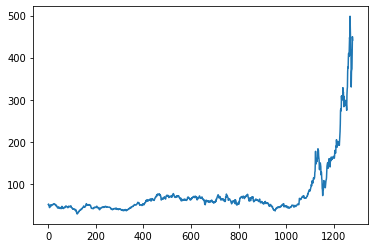

In [11]:
plt.plot(dataset)

In [12]:
dataset

,Adj Close
0,50.998001
1,52.144001
2,51.049999
3,48.436001
4,46.153999
...,...
1276,371.339996
1277,372.720001
1278,419.619995
1279,449.760010


In [13]:
# split the dataset into training set and testing set(last 20 days)
forecast_days = 20
split_point = len(dataset) - forecast_days

# create the arrays of the training and testing set
train, test = dataset.iloc[0:split_point, :].values, dataset.iloc[split_point:len(dataset), :].values

In [14]:
print('train.shape : ', train.shape)
print('test.shape  : ', test.shape)

train.shape :  (1261, 1)
test.shape  :  (20, 1)


## **2. Data Preprocessing**
### Feature Scaling
Feature scaling is necessary for LSTM because LSTM is sensitive to the scale of the data. We will use normalisationis because RNN prefer 'Sigmoid' as the activation function.

In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) # values are between (0,1)
train_scaled = sc.fit_transform(train)

In [16]:
print('the matrix of train_scaled :', train_scaled.shape)

the matrix of train_scaled : (1261, 1)


### Data Structure
We need to set up the time series of the last 60 days as feature points(X) plus the last day as target point(Y).

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  for i in range(len(dataset)-time_steps-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY) # RNN only take arrays

### Time-steps
At each time t, our RNN would look at the n previous data points to predict the data at t+1. In this project, I use 60 time steps, corresponding to previous 60 closing prices, roughly three months.

X_train - the stock prices of the previous 60 days(0th to 59th)

y_train - the stock price on the 60th day 

In [18]:
time_steps = 60
X_train, y_train = create_dataset(train_scaled, time_steps)

In [19]:
print(X_train)

[[0.06385152 0.06713816 0.06400064 ... 0.05053286 0.05087128 0.04683898]
 [0.06713816 0.06400064 0.05650389 ... 0.05087128 0.04683898 0.04177421]
 [0.06400064 0.05650389 0.04995928 ... 0.04683898 0.04177421 0.04325407]
 ...
 [0.38105564 0.3853862  0.39229218 ... 0.73126381 0.70592282 0.8093804 ]
 [0.3853862  0.39229218 0.38614335 ... 0.70592282 0.8093804  0.84737474]
 [0.39229218 0.38614335 0.38728477 ... 0.8093804  0.84737474 0.86441592]]


In [20]:
print(y_train)

[0.04177421 0.04325407 0.03973226 ... 0.84737474 0.86441592 0.97048902]


In [21]:
print('Matrix of X_train : ', X_train.shape)
print('Matrix of y_train : ', y_train.shape)

Matrix of X_train :  (1200, 60)
Matrix of y_train :  (1200,)


### Reshape
LSTM layer is a recurrent layer. It expects a 3-dimensional input (batch_size, timesteps, input_dim). Hence we need to reshape the input layers be 3 dimensions.

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # we only have '1' indicator - price 

## **3. LSTM** **bold text**
The RNN is a regressor because we are forecasting the continous outcome of the prices. We will use 50 neurons for the LSTM layers. 50 neurons are good start. If there are too few neurons, the RNN cannot capture the trends well. We will also set 20% as the Dropout regularisation. It will ignore 20% (10 neurons) in each iteration of training in both forward and backward porprogation.

In [23]:
# import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [24]:
# initialising the RNN
model = Sequential()

# add the first LSTM layer and Dropout regularisation
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(Dropout(0.2))

# add the second LSTM layer and Dropout regularisation
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

# add the third LSTM layer and Dropout regularisation
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

# add the fourth LSTM layer and Dropout regularisation
model.add(LSTM(50))
model.add(Dropout(0.2))

## Output layer
We are predicting the only one outcome of the price at t+1. This is a one dimension output. Thus we set up the full connected dense layers with one unit to the previous LSTM layer. 

We choose Adam optimizer because it often captures the updated weights and it is useful in this particular project. 

The metric is mean squared error because the outcome is continous data.

I experimented several numbers of epochs and found that 50 epochs gave some convergences of the loss. Therefore, I think 50 is the right number of epochs.

In [25]:
# add the output layer
model.add(Dense(1))

# compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [27]:
# fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
38/38 [==============================] - 4s 106ms/step - loss: 0.0085
Epoch 2/25
38/38 [==============================] - 4s 108ms/step - loss: 0.0031
Epoch 3/25
38/38 [==============================] - 4s 109ms/step - loss: 0.0022
Epoch 4/25
38/38 [==============================] - 4s 108ms/step - loss: 0.0017
Epoch 5/25
38/38 [==============================] - 4s 109ms/step - loss: 0.0018
Epoch 6/25
38/38 [==============================] - 4s 109ms/step - loss: 0.0019
Epoch 7/25
38/38 [==============================] - 6s 155ms/step - loss: 0.0020
Epoch 8/25
38/38 [==============================] - 6s 159ms/step - loss: 0.0017
Epoch 9/25
38/38 [==============================] - 4s 108ms/step - loss: 0.0014
Epoch 10/25
38/38 [==============================] - 4s 109ms/step - loss: 0.0015
Epoch 11/25
38/38 [==============================] - 4s 109ms/step - loss: 0.0014
Epoch 12/25
38/38 [==============================] - 4s 108ms/step - loss: 0.0011
Epoch 13/25
38/38 [======

##**4. Prediction**
###getting the real stock price
The real stock price is the prices from the last 20 trading days (roughly a month) on the full dataset.

In [28]:
real_price = test

Making prediction of the trend of last month and visulaising the results. As the RNN is based on the prices of the previous 60days, we have to create a new variable 'inputs' to keep the prices of the previous 60 days for predicting the 'X_test'.
We also need to inverse_transform the predicted prices because the data is scaled with normalisation.

In [29]:
inputs = dataset[len(dataset)-len(test)-60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 80):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [30]:
predicted_stock_price

array([[331.81882],
       [345.7354 ],
       [360.77798],
       [375.47098],
       [387.74835],
       [396.13504],
       [401.10648],
       [403.976  ],
       [405.35062],
       [407.84915],
       [411.4303 ],
       [414.1468 ],
       [413.07953],
       [407.94556],
       [396.57608],
       [381.03036],
       [364.32755],
       [349.4007 ],
       [340.13895],
       [339.9082 ]], dtype=float32)

In [31]:
predicted_stock_price.shape

(20, 1)

##**5. Evaluation**
As the RNN is a regressor predicting the continous outcome. We will use the metric of RMSE (Root Mean Squared Error) to evaluate the model performance. RMSE is the root mean of the squared differences between the predicted stock prices and the real stock prices.

However, we are building the RNN to predict the trend of Tesla, rather than the exact prices. It is because predictions could indeed be close to the real prices but could be the opposite direction from the real stock price. Thus, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions. We are trying to see if the RNN could show the same directions as the real stock prices. It does not matter much on how close the predicted prices to the real stock price. 

Anyhow, let's check the evaluatin as practise. We get the RMSE of 53. Considering the wide price fluctuation between 325 to 500 in a month period, It is an reasonable error. 

In [32]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_price, predicted_stock_price))
print('the mean squared error :' , rmse)

the mean squared error : 55.77092303690704


###**6. Visualisation**
The graph shows a decent predicted trend capturing the general direction of the real prices. It is normal that the graph is lag behind because it is extremely difficult to capture nonlinear trend. One reason of that is the stock markets consists of many factors such as quantitive and sentiment elements. The later one cannot be predicted. 
Nevertheless, the graph capture the smooth trend in both upward and downward trends.


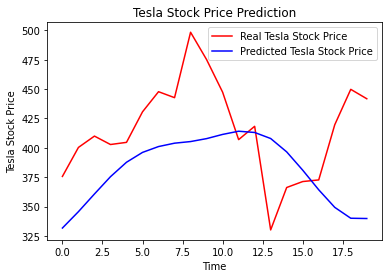

In [33]:
plt.plot(real_price, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

###**7. Improvement**

We can improve the RNN by few approaches:
1. getting more training data: such as 10 years instead of 5 years. 

2. increasing the number of timesteps: such as half year.

3. adding more neurones in the LSTM layers: increasing the number of neurons and layers to respond better to the complexity of the problem.



